In [2]:

import json

import albumentations as A
import cv2
import numpy as np
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch

from settings import BASE_DIR

In [101]:

def plot_img(image, landmarks=None, circles=None, circles2=None, landmarks2=None):
    """
    image: np.array of shape (c, h, w)
    landmarks: np.array of shape (n, 2)
    circles: np.array of shape (n, 3)
    """
    plt.imshow(np.moveaxis(np.array(image), 0, -1))
    if landmarks is not None and len(landmarks) > 0:
        x = landmarks[:, 0]
        y = landmarks[:, 1]
        plt.scatter(x, y)
    if circles is not None and len(circles) > 0:
        for circle in circles:
            xc, yc, r = circle
            plt.gca().add_patch(plt.Circle((xc, yc), r, fill=False))

    if landmarks2 is not None and len(landmarks2) > 0:
        x = landmarks2[:, 0]
        y = landmarks2[:, 1]
        plt.scatter(x, y, color='red')

    if circles2 is not None and len(circles2) > 0:
        for circle in circles2:
            xc, yc, r = circle
            plt.gca().add_patch(plt.Circle((xc, yc), r, color='red', fill=False))



In [4]:
transform = A.Compose (
    [
        # A.Resize(height=300, width=400),
        A.RandomSizedCrop(min_max_height=(250, 250), height=300, width=400, p=0.5),
        # A.CenterCrop(height=200, width=200),
        A.ToGray(p=0.1),
        A.Rotate(limit=40, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        # A.RandomScale(p=1),
        # A.Lambda(image=lambda x: x/255, keypoint=lambda x: x/255),
        A.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255),
        # ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

In [49]:
class IrisImageDataset(Dataset):
    def __init__(self, images_dir, labels_path, transform=None):
        super(IrisImageDataset, self).__init__()
        self.data = []
        self.images_dir = images_dir
        self.labels_path = labels_path
        self.transform = transform

        with open(labels_path) as json_file:
            self.labels = json.load(json_file)

        self.image_names = sorted(list(self.labels.keys()))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        label = self.labels[image_name]
        image = Image.open(f'{self.images_dir}/{image_name}.tiff')
        image = np.array(image)

        inner_landmarks = label['inner']['landmarks']
        outer_landmarks = label['outer']['landmarks']
        inner_circle = label['inner'].get('circles')
        center = [[inner_circle['xc'], inner_circle['yc']]] if inner_circle else []

        landmarks = inner_landmarks + outer_landmarks + center

        if self.transform:
            augmentations = self.transform(image=image, keypoints=landmarks)
            image = augmentations['image']
            landmarks = augmentations['keypoints']

        image = np.moveaxis(image, -1, 0)
        return image, landmarks

In [50]:
data_dir = f'{BASE_DIR}/data/pupil'
images_dir = f'{data_dir}/images'
labels_path = f'{data_dir}/labels.json'

In [51]:
dataset = IrisImageDataset(images_dir=images_dir,labels_path=labels_path,transform=transform)

In [52]:
p = None
for x,y in dataset:
    p = x, y
    break

In [53]:
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [91]:
class IrisLandmarks(nn.Module):
    """
    Input to this would be an image
    output should be a few points. How many? 6 inner + 6 outer + 1 center, total 13 + 13 = 26 points.
    Lets do something to make it easier to predict.
    lets do this in stages.
    1. Just predict all points as fraction of w and h
    2. Predict all points offsets from center
    3. he center point will be an offset from center of the image. Then rest will be offset to center.
       (This should confuse the network, right? So we define another way in the next)
    4. Crop the square from center. Center would be an offset from image center.
       All other points will be offset from center point in the crop
    """
    def __init__(self):
        super(IrisLandmarks, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 8, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8, 8, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Conv2d(8, 16, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Conv2d(16, 32, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 38, 50

            nn.Conv2d(32, 64, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 19, 25

            nn.Conv2d(64, 128, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 10, 13

            nn.Conv2d(128, 256, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256, 256, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 5, 7

            nn.Conv2d(256, 512, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(512, 64, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 3, 4

            nn.Flatten(),

            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 26)
        )

    def forward(self, x):
        return self.features(x)


model = IrisLandmarks()
optim = torch.optim.Adam(model.parameters())

torch.Size([1, 26])


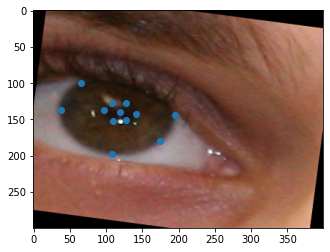

In [104]:
for image, landmarks in train_loader:
    plot_img(image[0], np.array(landmarks))
    y = model(image)
    print(y.shape)
    break
